In [3]:
import numpy as np 
import pymultinest as pmn
import bagpipes as pipes
from astropy.table import Table
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from tqdm import tqdm

#### filter curves

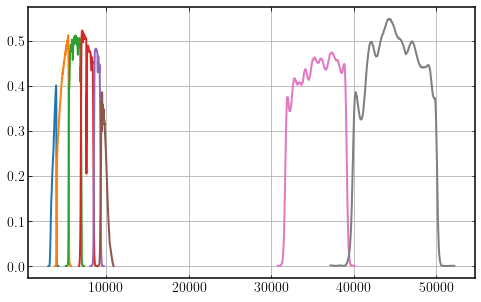

In [27]:
#clauds/hsc filter curves 
curve_u = 'hsc_responses_all_rev3/U.MP9302.txt'
curve_g = 'hsc_responses_all_rev3/hsc_g_v2018.dat'
curve_r = 'hsc_responses_all_rev3/hsc_r_v2018.dat'
curve_i = 'hsc_responses_all_rev3/hsc_i_v2018.dat'
curve_z = 'hsc_responses_all_rev3/hsc_z_v2018.dat'
curve_y = 'hsc_responses_all_rev3/hsc_y_v2018.dat'
curve_ch1 = 'candels_pipes_test/obs_filters/IRAC_1.txt'
curve_ch2 = 'candels_pipes_test/obs_filters/IRAC_2.txt'

#plot with new u_band
# curve_u = 'hsc_responses_all_rev3/cfh9301_norm.txt'
filt_list = [curve_u,curve_g,curve_r,curve_i,curve_z,curve_y, curve_ch1, curve_ch2]
plt.figure(figsize = (8, 5))
for filt in filt_list:
    fi = ascii.read(filt)
    plt.plot(fi['col1'], fi['col2'], '-')
plt.grid()
plt.show()


#### useful functions

In [25]:
def load_gal(ID):
    cat = Table.read('clauds_hsc_shiraz_massive.fits')
    gal = cat[cat['ID']==ID]

    u, g, r, i, z, y, ch1,ch2 = gal['u'], gal['g'], gal['r'], gal['i'], gal['z'], gal['y'],gal['MAG_AUTO_CH1'],gal['MAG_AUTO_CH2']
    uerr, gerr, rerr, ierr, zerr, yerr,ch1err, ch2err = gal['u_err'], gal['g_err'], gal['r_err'], gal['i_err'], gal['z_err'], gal['y_err'],gal['MAGERR_AUTO_CH1'],gal['MAGERR_AUTO_CH2']

    mags = np.array([u, g, r, i, z, y, ch1, ch2])
    magerrs = np.array([uerr, gerr, rerr, ierr, zerr, yerr, ch1err, ch2err])

    # mag correction (Sawicki & Yee 1997)
#     i_corr = gal['i'] - gal['MAG_APER_2s_i']
#     mags = mags + i_corr
#     magerrs = np.sqrt(gal['i_err'] ** 2 + magerrs ** 2)

    fluxes = ab2Jy(mags)
    fluxerrs = aberr2Jy(mags, magerrs)
    photometry = np.c_[fluxes, fluxerrs]
    
    for i in range(len(photometry)):
        photometry[i, 0] = photometry[i, 0]*1e6  # conversion from Jy to mJy
        photometry[i, 1] = photometry[i, 1]*1e6  # conversion from Jy to mJy
        
        # NaNs and 0s
        if (photometry[i, 0] <= 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**9.]
    
    # Enforce a maximum SNR of 20.
    for i in range(len(photometry)):
        max_snr = 20.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr      
    return photometry

def Jy2ab(flux):
    return 2.5*(23-np.log10(flux))-48.6

def ab2Jy(mag):
    return 10**(23-(mag+48.6)/2.5)

def aberr2Jy(mag,magerr):
    return 5811.33*np.e**(-0.921034*mag)*magerr

def Jyerr2ab(flux, fluxerr):
    return 1.08574/flux*fluxerr

#### load in data

In [7]:
cat = Table.read('clauds_hsc_shiraz_massive.fits')
cat_z = cat[abs(cat['ZPHOT']-0.4)<0.1]

In [30]:
gal = cat_z[20]
print(gal['ZPHOT'])
print(gal['MASS_MED'])

0.42
11.7074


#### fitting parameters

In [31]:
# exp = {}                                  # Tau-model star-formation history component
# exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
#                                           # the code automatically limits this to the age of
#                                           # the Universe at the observed redshift.
        
# exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
# exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
# exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

delayed = {}
delayed["age"] = (0.1, 14.)                 # time since first star forming
delayed["tau"] = (0.1, 10.0)                # timescale of star 🌟 forming
delayed["massformed"] = (6., 14.)             
delayed["metallicity"] = (0., 2.)   

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

nebular = {}
nebular["logU"] = -2          # Log_10 of the ionization parameter.
    
# The fit instructions dictionary
fit_instructions = {}    
fit_instructions["redshift"] = (0., 4.)
fit_instructions["redshift_prior"] = "Gaussian"
fit_instructions["redshift_prior_mu"] = gal['ZPHOT']
fit_instructions["redshift_prior_sigma"] =  0.04

fit_instructions["delayed"] = delayed
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular

fit_instructions

{'redshift': (0.0, 4.0),
 'redshift_prior': 'Gaussian',
 'redshift_prior_mu': 0.42,
 'redshift_prior_sigma': 0.04,
 'delayed': {'age': (0.1, 14.0),
  'tau': (0.1, 10.0),
  'massformed': (6.0, 14.0),
  'metallicity': (0.0, 2.0)},
 'dust': {'type': 'Calzetti', 'Av': (0.0, 2.0)},
 'nebular': {'logU': -2}}

#### fitting

In [32]:
galaxy = pipes.galaxy(gal['ID'], load_gal, spectrum_exists=False, filt_list = filt_list)

/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


v5006

Bagpipes: fitting object 206016


Completed in 24.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    5.482      7.143      8.323
delayed:massformed            11.599     11.677     11.749
delayed:metallicity            0.334      0.634      1.022
delayed:tau                    0.181      0.384      0.625
dust:Av                        0.106      0.329      0.571
redshift                       0.394      0.421      0.441





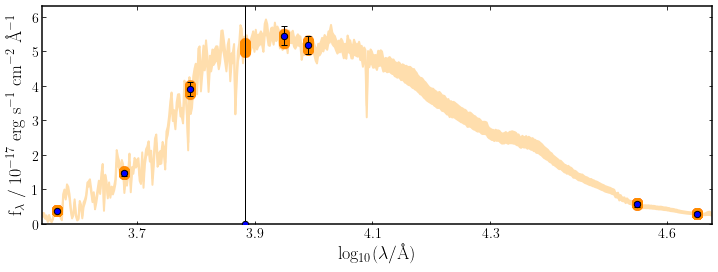

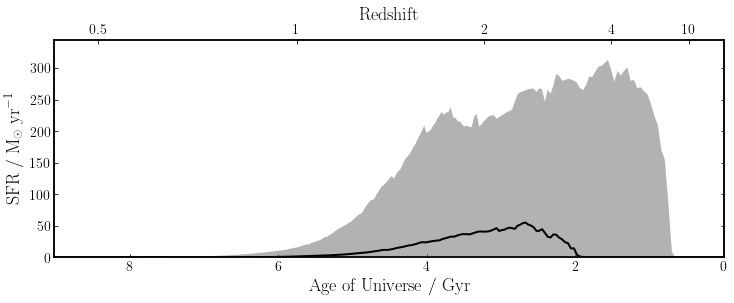

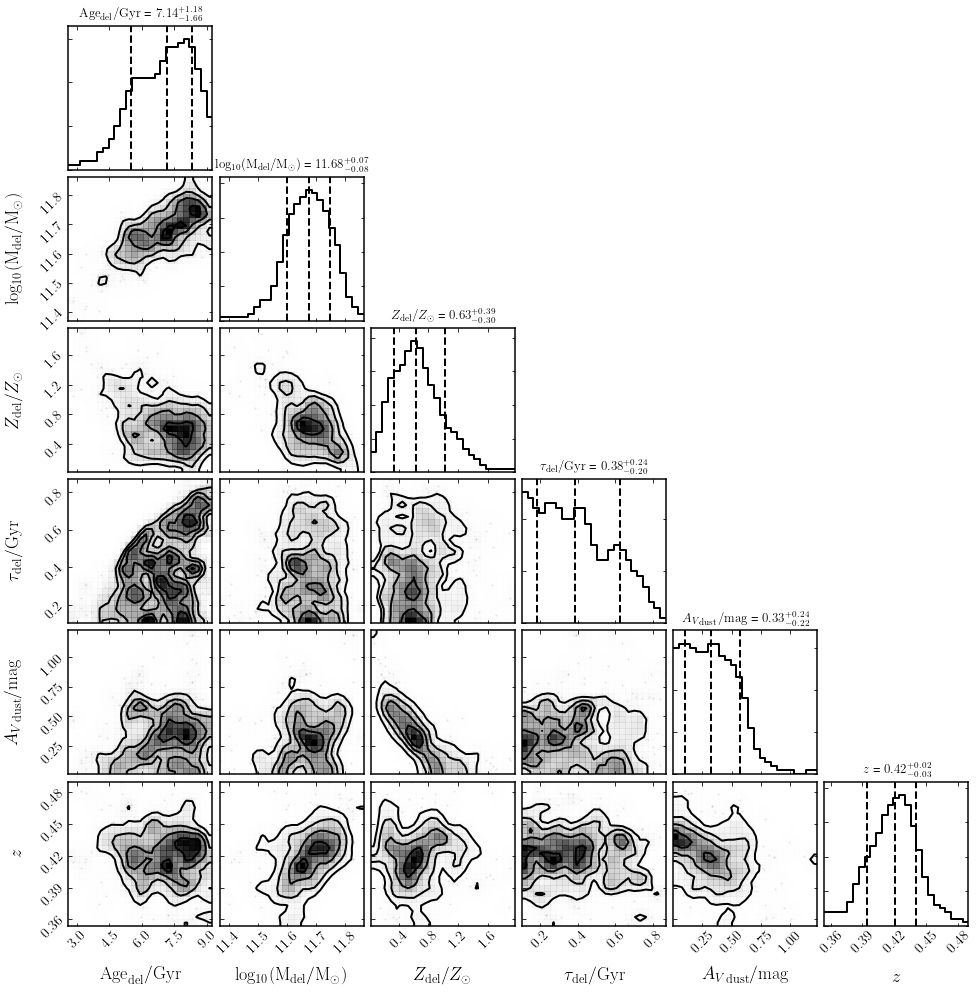

In [33]:
a = np.random.randint(10000)
print('v'+str(a))

fit = pipes.fit(galaxy, fit_instructions, run="v"+str(a))
fit.fit(verbose=False, n_live=100)
print()
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)
